In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

import gensim
import matplotlib.pyplot as plt

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('dev.csv')
data.columns = ['Text', 'Label']
data.head(50)

,Text,Label
0,Buses approaching to this place is highly unsafe.,1
1,a man was commenting at me.,1
2,in a share auto,0
3,I was coming out of a club at night with a few...,1
4,One of my friends was molested in the crowd. T...,0
5,I was travelling in metro heading to my colleg...,0
6,A guy masturbating at the roadside and ogling....,1
7,"When I was travelling in red line metro , a gu...",0
8,Late evening (around 7.30 pm) after shopping i...,0
9,For a week in the morning when I found be taki...,1


In [3]:
data.Label.unique()

array([1, 0], dtype=int64)

In [4]:
data.shape

(991, 2)

In [5]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [6]:
data['Pos']= pos
data['Neg']= neg

In [7]:
data.head()

,Text,Label,Pos,Neg
0,Buses approaching to this place is highly unsafe.,1,1,0
1,a man was commenting at me.,1,1,0
2,in a share auto,0,0,1
3,I was coming out of a club at night with a few...,1,1,0
4,One of my friends was molested in the crowd. T...,0,0,1


# Cleaning the data

In [8]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [9]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean] 

In [10]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]  
lower_tokens = [lower_token(token) for token in tokens] 

In [11]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [12]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [13]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [14]:
result = [' '.join(sen) for sen in filtered_words] 

In [15]:
data['Text_Final'] = result

In [16]:
data['tokens'] = filtered_words

In [17]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [18]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,buses approaching place highly unsafe,"[buses, approaching, place, highly, unsafe]",1,1,0
1,man commenting,"[man, commenting]",1,1,0
2,share auto,"[share, auto]",0,0,1
3,coming club night friends guys came stopped us...,"[coming, club, night, friends, guys, came, sto...",1,1,0


# Split data into test and train

In [19]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [20]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

9742 words total, with a vocabulary size of 2634
Max sentence length is 116


In [21]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

1021 words total, with a vocabulary size of 566
Max sentence length is 48


# Load Google News Word2Vec model

In [22]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [23]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [24]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Get Embeddings

In [25]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [26]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

# Tokenize and Pad Sequences

In [27]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 2634 unique tokens.


In [28]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(2635, 300)


In [30]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define CNN

In [31]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [32]:
label_names = ['Pos', 'Neg']

In [33]:
y_train = data_train[label_names].values

In [34]:
x_train = train_cnn_data
y_tr = y_train

In [35]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      790500      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

# Train CNN

In [36]:
num_epochs = 10000
batch_size = 34

In [37]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10000
24/24 [==============================] - 2s 49ms/step - loss: 0.6486 - acc: 0.6604 - val_loss: 0.5564 - val_acc: 0.7667
Epoch 2/10000
24/24 [==============================] - 1s 48ms/step - loss: 0.4471 - acc: 0.8202 - val_loss: 0.5304 - val_acc: 0.7889
Epoch 3/10000
24/24 [==============================] - 1s 53ms/step - loss: 0.3107 - acc: 0.8826 - val_loss: 0.5571 - val_acc: 0.7778
Epoch 4/10000
24/24 [==============================] - 1s 56ms/step - loss: 0.1943 - acc: 0.9276 - val_loss: 0.5782 - val_acc: 0.7889
Epoch 5/10000
24/24 [==============================] - 1s 60ms/step - loss: 0.1149 - acc: 0.9675 - val_loss: 0.6427 - val_acc: 0.7889
Epoch 6/10000
24/24 [==============================] - 1s 57ms/step - loss: 0.0847 - acc: 0.9813 - val_loss: 0.7031 - val_acc: 0.7333
Epoch 7/10000
24/24 [==============================] - 1s 56ms/step - loss: 0.0804 - acc: 0.9775 - val_loss: 0.7177 - val_acc: 0.7778
Epoch 8/10000
24/24 [==============================] - 1s 53ms

Epoch 62/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0304 - acc: 0.9863 - val_loss: 1.2830 - val_acc: 0.8000
Epoch 63/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 1.3240 - val_acc: 0.7889
Epoch 64/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0291 - acc: 0.9850 - val_loss: 1.4543 - val_acc: 0.7778
Epoch 65/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 1.3773 - val_acc: 0.7778
Epoch 66/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0302 - acc: 0.9838 - val_loss: 1.3268 - val_acc: 0.8000
Epoch 67/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0289 - acc: 0.9863 - val_loss: 1.4008 - val_acc: 0.7778
Epoch 68/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 1.3170 - val_acc: 0.8111
Epoch 69/10000
24/24 [==============================] -

24/24 [==============================] - 1s 33ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 1.5800 - val_acc: 0.7889
Epoch 123/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0295 - acc: 0.9863 - val_loss: 1.5813 - val_acc: 0.8000
Epoch 124/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 1.5987 - val_acc: 0.7889
Epoch 125/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 1.5745 - val_acc: 0.8000
Epoch 126/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0298 - acc: 0.9850 - val_loss: 1.6165 - val_acc: 0.7889
Epoch 127/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0286 - acc: 0.9850 - val_loss: 1.6060 - val_acc: 0.7889
Epoch 128/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 1.5745 - val_acc: 0.8111
Epoch 129/10000
24/24 [==============================] - 1s 34ms

24/24 [==============================] - 1s 34ms/step - loss: 0.0292 - acc: 0.9863 - val_loss: 1.7520 - val_acc: 0.7778
Epoch 183/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 1.7356 - val_acc: 0.7778
Epoch 184/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 1.7333 - val_acc: 0.7778
Epoch 185/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 1.8361 - val_acc: 0.7889
Epoch 186/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 1.8726 - val_acc: 0.7889
Epoch 187/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0320 - acc: 0.9850 - val_loss: 2.0773 - val_acc: 0.7778
Epoch 188/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0490 - acc: 0.9825 - val_loss: 1.6111 - val_acc: 0.7778
Epoch 189/10000
24/24 [==============================] - 1s 34ms

24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 2.0175 - val_acc: 0.7889
Epoch 243/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 2.0253 - val_acc: 0.7889
Epoch 244/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.0742 - val_acc: 0.7889
Epoch 245/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 2.0797 - val_acc: 0.7889
Epoch 246/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.0658 - val_acc: 0.7889
Epoch 247/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 2.0664 - val_acc: 0.7889
Epoch 248/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 2.0971 - val_acc: 0.7889
Epoch 249/10000
24/24 [==============================] - 1s 35ms

24/24 [==============================] - 1s 35ms/step - loss: 0.0296 - acc: 0.9863 - val_loss: 1.9035 - val_acc: 0.8111
Epoch 303/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 1.7925 - val_acc: 0.8222
Epoch 304/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 1.8057 - val_acc: 0.8222
Epoch 305/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 1.8217 - val_acc: 0.8222
Epoch 306/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0292 - acc: 0.9863 - val_loss: 1.9020 - val_acc: 0.8222
Epoch 307/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 1.9629 - val_acc: 0.8111
Epoch 308/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 1.9083 - val_acc: 0.8222
Epoch 309/10000
24/24 [==============================] - 1s 34ms

24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 2.5592 - val_acc: 0.8000
Epoch 363/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 2.5238 - val_acc: 0.8000
Epoch 364/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 2.6056 - val_acc: 0.8000
Epoch 365/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0287 - acc: 0.9863 - val_loss: 2.6176 - val_acc: 0.8000
Epoch 366/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 2.4358 - val_acc: 0.7889
Epoch 367/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.4154 - val_acc: 0.7889
Epoch 368/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 2.4799 - val_acc: 0.7889
Epoch 369/10000
24/24 [==============================] - 1s 35ms

24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 2.0582 - val_acc: 0.7667
Epoch 423/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 2.0686 - val_acc: 0.7667
Epoch 424/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 2.0816 - val_acc: 0.7667
Epoch 425/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 2.1242 - val_acc: 0.7667
Epoch 426/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 2.1236 - val_acc: 0.7667
Epoch 427/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 2.1334 - val_acc: 0.7667
Epoch 428/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 2.1114 - val_acc: 0.7667
Epoch 429/10000
24/24 [==============================] - 1s 36ms

24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 2.3478 - val_acc: 0.7556
Epoch 483/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 2.3628 - val_acc: 0.7556
Epoch 484/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 2.3681 - val_acc: 0.7556
Epoch 485/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 2.3823 - val_acc: 0.7556
Epoch 486/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 2.4007 - val_acc: 0.7667
Epoch 487/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.4149 - val_acc: 0.7667
Epoch 488/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0306 - acc: 0.9863 - val_loss: 2.4024 - val_acc: 0.7667
Epoch 489/10000
24/24 [==============================] - 1s 35ms

24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 2.9600 - val_acc: 0.7778
Epoch 543/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 2.9666 - val_acc: 0.7778
Epoch 544/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 3.0029 - val_acc: 0.7667
Epoch 545/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 3.0050 - val_acc: 0.7667
Epoch 546/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 2.9991 - val_acc: 0.7667
Epoch 547/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.0161 - val_acc: 0.7667
Epoch 548/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.2143 - val_acc: 0.7778
Epoch 549/10000
24/24 [==============================] - 1s 35ms

24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.1439 - val_acc: 0.7667
Epoch 603/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.1464 - val_acc: 0.7667
Epoch 604/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 3.1499 - val_acc: 0.7667
Epoch 605/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.1555 - val_acc: 0.7667
Epoch 606/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.1737 - val_acc: 0.7778
Epoch 607/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.2043 - val_acc: 0.7778
Epoch 608/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.2172 - val_acc: 0.7778
Epoch 609/10000
24/24 [==============================] - 1s 32ms

24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 3.2151 - val_acc: 0.7778
Epoch 663/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 3.2076 - val_acc: 0.7667
Epoch 664/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 3.2110 - val_acc: 0.7667
Epoch 665/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 3.1967 - val_acc: 0.7667
Epoch 666/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 3.1862 - val_acc: 0.7667
Epoch 667/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.1871 - val_acc: 0.7667
Epoch 668/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 3.2003 - val_acc: 0.7556
Epoch 669/10000
24/24 [==============================] - 1s 33ms

24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 3.4980 - val_acc: 0.7667
Epoch 723/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 3.5075 - val_acc: 0.7778
Epoch 724/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.5954 - val_acc: 0.7778
Epoch 725/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 3.6059 - val_acc: 0.7778
Epoch 726/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 3.6060 - val_acc: 0.7889
Epoch 727/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 3.6112 - val_acc: 0.7889
Epoch 728/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 3.6125 - val_acc: 0.7889
Epoch 729/10000
24/24 [==============================] - 1s 33ms

24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 2.6211 - val_acc: 0.7778
Epoch 783/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 2.6402 - val_acc: 0.7778
Epoch 784/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0265 - acc: 0.9863 - val_loss: 2.6523 - val_acc: 0.7778
Epoch 785/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.7122 - val_acc: 0.7778
Epoch 786/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 2.7810 - val_acc: 0.7778
Epoch 787/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 2.8922 - val_acc: 0.7778
Epoch 788/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 2.8637 - val_acc: 0.7778
Epoch 789/10000
24/24 [==============================] - 1s 32ms

24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 2.9323 - val_acc: 0.7889
Epoch 843/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 2.9276 - val_acc: 0.7889
Epoch 844/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 2.9463 - val_acc: 0.8000
Epoch 845/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 2.9610 - val_acc: 0.8000
Epoch 846/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 2.9673 - val_acc: 0.8000
Epoch 847/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 2.9867 - val_acc: 0.7889
Epoch 848/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 2.9883 - val_acc: 0.8000
Epoch 849/10000
24/24 [==============================] - 1s 34ms

24/24 [==============================] - 1s 33ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 3.1007 - val_acc: 0.8000
Epoch 903/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 3.1036 - val_acc: 0.8000
Epoch 904/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 3.0931 - val_acc: 0.8000
Epoch 905/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 3.0858 - val_acc: 0.8000
Epoch 906/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.0932 - val_acc: 0.8000
Epoch 907/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.0472 - val_acc: 0.7889
Epoch 908/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 3.0504 - val_acc: 0.7889
Epoch 909/10000
24/24 [==============================] - 1s 34ms

24/24 [==============================] - 1s 44ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 3.3808 - val_acc: 0.7889
Epoch 963/10000
24/24 [==============================] - 1s 43ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 3.3335 - val_acc: 0.7889
Epoch 964/10000
24/24 [==============================] - 1s 43ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 3.3298 - val_acc: 0.8000
Epoch 965/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0264 - acc: 0.9850 - val_loss: 3.3265 - val_acc: 0.8000
Epoch 966/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 3.5587 - val_acc: 0.7889
Epoch 967/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.5496 - val_acc: 0.7889
Epoch 968/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 3.5095 - val_acc: 0.8111
Epoch 969/10000
24/24 [==============================] - 1s 41ms

24/24 [==============================] - 1s 40ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 3.3179 - val_acc: 0.7778
Epoch 1023/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 3.3439 - val_acc: 0.7778
Epoch 1024/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 3.3386 - val_acc: 0.7778
Epoch 1025/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 3.3502 - val_acc: 0.7778
Epoch 1026/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0287 - acc: 0.9838 - val_loss: 3.2965 - val_acc: 0.7444
Epoch 1027/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 3.3977 - val_acc: 0.7778
Epoch 1028/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0312 - acc: 0.9838 - val_loss: 3.2904 - val_acc: 0.7333
Epoch 1029/10000
24/24 [==============================] - 

Epoch 1082/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 3.5203 - val_acc: 0.7667
Epoch 1083/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 3.5388 - val_acc: 0.7667
Epoch 1084/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0288 - acc: 0.9850 - val_loss: 3.5062 - val_acc: 0.7556
Epoch 1085/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 3.5001 - val_acc: 0.7556
Epoch 1086/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 3.5097 - val_acc: 0.7556
Epoch 1087/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0266 - acc: 0.9863 - val_loss: 3.5389 - val_acc: 0.7556
Epoch 1088/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 3.5894 - val_acc: 0.7556
Epoch 1089/10000
24/24 [=================

Epoch 1142/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 3.9631 - val_acc: 0.7667
Epoch 1143/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 3.9593 - val_acc: 0.7667
Epoch 1144/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 3.9589 - val_acc: 0.7667
Epoch 1145/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.9472 - val_acc: 0.7667
Epoch 1146/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 3.9382 - val_acc: 0.7667
Epoch 1147/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.9354 - val_acc: 0.7667
Epoch 1148/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.9534 - val_acc: 0.7667
Epoch 1149/10000
24/24 [=================

Epoch 1202/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 3.7433 - val_acc: 0.7556
Epoch 1203/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 3.7357 - val_acc: 0.7556
Epoch 1204/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.7517 - val_acc: 0.7556
Epoch 1205/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 3.7332 - val_acc: 0.7444
Epoch 1206/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 3.7422 - val_acc: 0.7556
Epoch 1207/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0262 - acc: 0.9875 - val_loss: 3.7496 - val_acc: 0.7444
Epoch 1208/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 3.7539 - val_acc: 0.7444
Epoch 1209/10000
24/24 [=================

Epoch 1262/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 4.2419 - val_acc: 0.7667
Epoch 1263/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 4.1624 - val_acc: 0.7667
Epoch 1264/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 4.1630 - val_acc: 0.7667
Epoch 1265/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 4.1612 - val_acc: 0.7667
Epoch 1266/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 4.1664 - val_acc: 0.7667
Epoch 1267/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 4.1459 - val_acc: 0.7667
Epoch 1268/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 4.1376 - val_acc: 0.7667
Epoch 1269/10000
24/24 [=================

Epoch 1322/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 3.9354 - val_acc: 0.7667
Epoch 1323/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.9587 - val_acc: 0.7556
Epoch 1324/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 3.9852 - val_acc: 0.7667
Epoch 1325/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 3.9646 - val_acc: 0.7556
Epoch 1326/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 3.9948 - val_acc: 0.7667
Epoch 1327/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 4.0102 - val_acc: 0.7667
Epoch 1328/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 4.0227 - val_acc: 0.7667
Epoch 1329/10000
24/24 [=================

Epoch 1382/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0288 - acc: 0.9850 - val_loss: 4.3317 - val_acc: 0.7556
Epoch 1383/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0287 - acc: 0.9863 - val_loss: 5.1872 - val_acc: 0.7556
Epoch 1384/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 5.1361 - val_acc: 0.7556
Epoch 1385/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 4.7676 - val_acc: 0.7778
Epoch 1386/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 4.2891 - val_acc: 0.7778
Epoch 1387/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 4.0816 - val_acc: 0.7667
Epoch 1388/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 4.0549 - val_acc: 0.7667
Epoch 1389/10000
24/24 [=================

Epoch 1442/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.0019 - val_acc: 0.7667
Epoch 1443/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0328 - acc: 0.9838 - val_loss: 4.1634 - val_acc: 0.7889
Epoch 1444/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 3.6768 - val_acc: 0.7667
Epoch 1445/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 3.4116 - val_acc: 0.7667
Epoch 1446/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 3.4151 - val_acc: 0.7667
Epoch 1447/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 3.4632 - val_acc: 0.7667
Epoch 1448/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0283 - acc: 0.9888 - val_loss: 3.4441 - val_acc: 0.7667
Epoch 1449/10000
24/24 [=================

Epoch 1502/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 3.9654 - val_acc: 0.7667
Epoch 1503/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 3.9817 - val_acc: 0.7667
Epoch 1504/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 3.9891 - val_acc: 0.7667
Epoch 1505/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 3.9845 - val_acc: 0.7667
Epoch 1506/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0286 - acc: 0.9875 - val_loss: 3.9736 - val_acc: 0.7667
Epoch 1507/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 3.9779 - val_acc: 0.7667
Epoch 1508/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 3.9474 - val_acc: 0.7667
Epoch 1509/10000
24/24 [=================

Epoch 1562/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 4.5428 - val_acc: 0.7778
Epoch 1563/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 4.5595 - val_acc: 0.7778
Epoch 1564/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 4.5190 - val_acc: 0.7778
Epoch 1565/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 4.5121 - val_acc: 0.7778
Epoch 1566/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9875 - val_loss: 4.4911 - val_acc: 0.7667
Epoch 1567/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 4.4978 - val_acc: 0.7778
Epoch 1568/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 4.4987 - val_acc: 0.7778
Epoch 1569/10000
24/24 [=================

Epoch 1622/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0287 - acc: 0.9850 - val_loss: 4.6436 - val_acc: 0.7667
Epoch 1623/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 4.6394 - val_acc: 0.7667
Epoch 1624/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 4.6348 - val_acc: 0.7667
Epoch 1625/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 4.6166 - val_acc: 0.7667
Epoch 1626/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 4.6171 - val_acc: 0.7667
Epoch 1627/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 4.6221 - val_acc: 0.7667
Epoch 1628/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 4.6114 - val_acc: 0.7667
Epoch 1629/10000
24/24 [=================

Epoch 1682/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0286 - acc: 0.9875 - val_loss: 4.3116 - val_acc: 0.7444
Epoch 1683/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9838 - val_loss: 4.7309 - val_acc: 0.7444
Epoch 1684/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 4.4735 - val_acc: 0.7444
Epoch 1685/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 4.2352 - val_acc: 0.7444
Epoch 1686/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 4.2010 - val_acc: 0.7444
Epoch 1687/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 4.2085 - val_acc: 0.7444
Epoch 1688/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0289 - acc: 0.9863 - val_loss: 4.2136 - val_acc: 0.7444
Epoch 1689/10000
24/24 [=================

Epoch 1742/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 4.8925 - val_acc: 0.7556
Epoch 1743/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0324 - acc: 0.9863 - val_loss: 4.9165 - val_acc: 0.7556
Epoch 1744/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 4.9792 - val_acc: 0.7556
Epoch 1745/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 4.9754 - val_acc: 0.7556
Epoch 1746/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 4.9849 - val_acc: 0.7556
Epoch 1747/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 4.9790 - val_acc: 0.7556
Epoch 1748/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 4.9989 - val_acc: 0.7556
Epoch 1749/10000
24/24 [=================

Epoch 1802/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 4.8837 - val_acc: 0.7667
Epoch 1803/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 4.8641 - val_acc: 0.7667
Epoch 1804/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0295 - acc: 0.9863 - val_loss: 5.0729 - val_acc: 0.7667
Epoch 1805/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 5.1293 - val_acc: 0.7667
Epoch 1806/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 5.1069 - val_acc: 0.7667
Epoch 1807/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 5.1282 - val_acc: 0.7667
Epoch 1808/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 5.1279 - val_acc: 0.7667
Epoch 1809/10000
24/24 [=================

Epoch 1862/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 5.1830 - val_acc: 0.7667
Epoch 1863/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 5.1757 - val_acc: 0.7667
Epoch 1864/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 5.1627 - val_acc: 0.7667
Epoch 1865/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 5.1828 - val_acc: 0.7667
Epoch 1866/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0289 - acc: 0.9850 - val_loss: 5.1930 - val_acc: 0.7667
Epoch 1867/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9838 - val_loss: 5.2009 - val_acc: 0.7667
Epoch 1868/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 5.2034 - val_acc: 0.7667
Epoch 1869/10000
24/24 [=================

Epoch 1922/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 5.0564 - val_acc: 0.7667
Epoch 1923/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 5.0555 - val_acc: 0.7667
Epoch 1924/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 5.0494 - val_acc: 0.7667
Epoch 1925/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 5.0468 - val_acc: 0.7667
Epoch 1926/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 5.0419 - val_acc: 0.7667
Epoch 1927/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 5.0537 - val_acc: 0.7667
Epoch 1928/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 5.0365 - val_acc: 0.7667
Epoch 1929/10000
24/24 [=================

Epoch 1982/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 4.9687 - val_acc: 0.7556
Epoch 1983/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 5.0394 - val_acc: 0.7556
Epoch 1984/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 4.6659 - val_acc: 0.7556
Epoch 1985/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 4.6615 - val_acc: 0.7667
Epoch 1986/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 4.6782 - val_acc: 0.7667
Epoch 1987/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 4.6765 - val_acc: 0.7667
Epoch 1988/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 4.6781 - val_acc: 0.7667
Epoch 1989/10000
24/24 [=================

Epoch 2042/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 5.6297 - val_acc: 0.7556
Epoch 2043/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 5.6790 - val_acc: 0.7556
Epoch 2044/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 5.6878 - val_acc: 0.7556
Epoch 2045/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 5.6944 - val_acc: 0.7556
Epoch 2046/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 5.6770 - val_acc: 0.7556
Epoch 2047/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 5.5939 - val_acc: 0.7556
Epoch 2048/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9875 - val_loss: 5.5881 - val_acc: 0.7556
Epoch 2049/10000
24/24 [=================

Epoch 2102/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 5.5338 - val_acc: 0.7556
Epoch 2103/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 5.5120 - val_acc: 0.7444
Epoch 2104/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 5.5113 - val_acc: 0.7444
Epoch 2105/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 5.5224 - val_acc: 0.7444
Epoch 2106/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 5.5345 - val_acc: 0.7444
Epoch 2107/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 5.5356 - val_acc: 0.7444
Epoch 2108/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 5.5185 - val_acc: 0.7444
Epoch 2109/10000
24/24 [=================

Epoch 2162/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0297 - acc: 0.9863 - val_loss: 6.5679 - val_acc: 0.7667
Epoch 2163/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0395 - acc: 0.9850 - val_loss: 7.2664 - val_acc: 0.7889
Epoch 2164/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0289 - acc: 0.9863 - val_loss: 6.2815 - val_acc: 0.7889
Epoch 2165/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 6.0476 - val_acc: 0.7778
Epoch 2166/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 6.1160 - val_acc: 0.7667
Epoch 2167/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 6.1581 - val_acc: 0.7667
Epoch 2168/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 6.1752 - val_acc: 0.7667
Epoch 2169/10000
24/24 [=================

Epoch 2222/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 5.8098 - val_acc: 0.7667
Epoch 2223/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 5.8047 - val_acc: 0.7667
Epoch 2224/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 5.7836 - val_acc: 0.7667
Epoch 2225/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 5.7924 - val_acc: 0.7667
Epoch 2226/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 5.7446 - val_acc: 0.7667
Epoch 2227/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 5.7620 - val_acc: 0.7667
Epoch 2228/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 5.7728 - val_acc: 0.7667
Epoch 2229/10000
24/24 [=================

Epoch 2282/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 5.4367 - val_acc: 0.7889
Epoch 2283/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 5.4481 - val_acc: 0.7889
Epoch 2284/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 5.4331 - val_acc: 0.7889
Epoch 2285/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 5.4281 - val_acc: 0.8000
Epoch 2286/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 5.4336 - val_acc: 0.7889
Epoch 2287/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 5.4410 - val_acc: 0.8000
Epoch 2288/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 5.4465 - val_acc: 0.8000
Epoch 2289/10000
24/24 [=================

Epoch 2342/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 5.6364 - val_acc: 0.8111
Epoch 2343/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 5.7576 - val_acc: 0.8111
Epoch 2344/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 5.8357 - val_acc: 0.8111
Epoch 2345/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 5.8291 - val_acc: 0.8111
Epoch 2346/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9888 - val_loss: 5.8366 - val_acc: 0.8111
Epoch 2347/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 5.8222 - val_acc: 0.8111
Epoch 2348/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 5.8194 - val_acc: 0.8111
Epoch 2349/10000
24/24 [=================

Epoch 2402/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 5.8406 - val_acc: 0.8111
Epoch 2403/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 5.8764 - val_acc: 0.8111
Epoch 2404/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 5.8963 - val_acc: 0.8111
Epoch 2405/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 5.8872 - val_acc: 0.8111
Epoch 2406/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 5.8680 - val_acc: 0.8111
Epoch 2407/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9888 - val_loss: 5.8734 - val_acc: 0.8111
Epoch 2408/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 5.8713 - val_acc: 0.8111
Epoch 2409/10000
24/24 [=================

Epoch 2462/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 5.9765 - val_acc: 0.8000
Epoch 2463/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 5.9644 - val_acc: 0.8000
Epoch 2464/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 5.9633 - val_acc: 0.8000
Epoch 2465/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 5.9657 - val_acc: 0.8000
Epoch 2466/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 5.9707 - val_acc: 0.8000
Epoch 2467/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 5.9606 - val_acc: 0.8000
Epoch 2468/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 6.0433 - val_acc: 0.8000
Epoch 2469/10000
24/24 [=================

Epoch 2522/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 6.5468 - val_acc: 0.8111
Epoch 2523/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 6.5395 - val_acc: 0.8111
Epoch 2524/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0288 - acc: 0.9850 - val_loss: 6.5387 - val_acc: 0.8111
Epoch 2525/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 6.5413 - val_acc: 0.8111
Epoch 2526/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 6.5467 - val_acc: 0.8111
Epoch 2527/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 6.5484 - val_acc: 0.8111
Epoch 2528/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 6.5422 - val_acc: 0.8111
Epoch 2529/10000
24/24 [=================

Epoch 2582/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 6.9545 - val_acc: 0.8000
Epoch 2583/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 6.9569 - val_acc: 0.8111
Epoch 2584/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0287 - acc: 0.9875 - val_loss: 6.9449 - val_acc: 0.8111
Epoch 2585/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 6.9593 - val_acc: 0.8111
Epoch 2586/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9888 - val_loss: 6.9725 - val_acc: 0.8111
Epoch 2587/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 6.9699 - val_acc: 0.8111
Epoch 2588/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 6.9753 - val_acc: 0.8111
Epoch 2589/10000
24/24 [=================

Epoch 2642/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 7.0535 - val_acc: 0.8000
Epoch 2643/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 7.0523 - val_acc: 0.8000
Epoch 2644/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 7.0690 - val_acc: 0.8000
Epoch 2645/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 7.0803 - val_acc: 0.8000
Epoch 2646/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 7.0806 - val_acc: 0.8000
Epoch 2647/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 7.0841 - val_acc: 0.8000
Epoch 2648/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 7.1127 - val_acc: 0.8000
Epoch 2649/10000
24/24 [=================

Epoch 2702/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0269 - acc: 0.9850 - val_loss: 7.7394 - val_acc: 0.7667
Epoch 2703/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9875 - val_loss: 7.7801 - val_acc: 0.7667
Epoch 2704/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 7.7748 - val_acc: 0.7667
Epoch 2705/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 7.7396 - val_acc: 0.7667
Epoch 2706/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 7.6832 - val_acc: 0.7667
Epoch 2707/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 7.6891 - val_acc: 0.7667
Epoch 2708/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 7.6956 - val_acc: 0.7667
Epoch 2709/10000
24/24 [=================

Epoch 2762/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 7.4874 - val_acc: 0.7778
Epoch 2763/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 7.5085 - val_acc: 0.7667
Epoch 2764/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 7.5463 - val_acc: 0.7556
Epoch 2765/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 7.5495 - val_acc: 0.7556
Epoch 2766/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9888 - val_loss: 7.5414 - val_acc: 0.7556
Epoch 2767/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9875 - val_loss: 7.5488 - val_acc: 0.7667
Epoch 2768/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 7.5454 - val_acc: 0.7556
Epoch 2769/10000
24/24 [=================

Epoch 2822/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 7.6839 - val_acc: 0.7889
Epoch 2823/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 7.6864 - val_acc: 0.7889
Epoch 2824/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 7.8448 - val_acc: 0.7778
Epoch 2825/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 7.8617 - val_acc: 0.7778
Epoch 2826/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 7.8561 - val_acc: 0.7778
Epoch 2827/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 7.8391 - val_acc: 0.7778
Epoch 2828/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 7.8031 - val_acc: 0.7778
Epoch 2829/10000
24/24 [=================

Epoch 2882/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 7.8207 - val_acc: 0.7889
Epoch 2883/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 7.8328 - val_acc: 0.7889
Epoch 2884/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 7.8287 - val_acc: 0.7889
Epoch 2885/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0288 - acc: 0.9875 - val_loss: 9.0562 - val_acc: 0.7667
Epoch 2886/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 8.1673 - val_acc: 0.7667
Epoch 2887/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 7.9574 - val_acc: 0.7667
Epoch 2888/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0284 - acc: 0.9875 - val_loss: 7.9500 - val_acc: 0.7667
Epoch 2889/10000
24/24 [=================

Epoch 2942/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0423 - acc: 0.9813 - val_loss: 5.8302 - val_acc: 0.7556
Epoch 2943/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0316 - acc: 0.9850 - val_loss: 6.5210 - val_acc: 0.7667
Epoch 2944/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 6.6623 - val_acc: 0.8000
Epoch 2945/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 6.4534 - val_acc: 0.8111
Epoch 2946/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0294 - acc: 0.9850 - val_loss: 6.4286 - val_acc: 0.8111
Epoch 2947/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0286 - acc: 0.9875 - val_loss: 6.4598 - val_acc: 0.8111
Epoch 2948/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0271 - acc: 0.9838 - val_loss: 6.4588 - val_acc: 0.8111
Epoch 2949/10000
24/24 [=================

Epoch 3002/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 7.3352 - val_acc: 0.7778
Epoch 3003/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 7.2813 - val_acc: 0.7889
Epoch 3004/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 7.2726 - val_acc: 0.7889
Epoch 3005/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 7.2811 - val_acc: 0.7889
Epoch 3006/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0294 - acc: 0.9850 - val_loss: 7.2779 - val_acc: 0.7889
Epoch 3007/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 7.2785 - val_acc: 0.7889
Epoch 3008/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 7.2741 - val_acc: 0.7889
Epoch 3009/10000
24/24 [=================

Epoch 3062/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 7.3814 - val_acc: 0.8000
Epoch 3063/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 7.4080 - val_acc: 0.8000
Epoch 3064/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0296 - acc: 0.9850 - val_loss: 7.3540 - val_acc: 0.8000
Epoch 3065/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 7.3729 - val_acc: 0.8000
Epoch 3066/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 7.3829 - val_acc: 0.8000
Epoch 3067/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9850 - val_loss: 7.3908 - val_acc: 0.8000
Epoch 3068/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 7.3937 - val_acc: 0.8000
Epoch 3069/10000
24/24 [=================

Epoch 3122/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 7.7548 - val_acc: 0.7889
Epoch 3123/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9838 - val_loss: 7.7764 - val_acc: 0.7889
Epoch 3124/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 7.7548 - val_acc: 0.7889
Epoch 3125/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 7.7563 - val_acc: 0.7889
Epoch 3126/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 7.7484 - val_acc: 0.7889
Epoch 3127/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 7.8216 - val_acc: 0.7889
Epoch 3128/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 7.8238 - val_acc: 0.7889
Epoch 3129/10000
24/24 [=================

Epoch 3182/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 7.5691 - val_acc: 0.8000
Epoch 3183/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 7.6016 - val_acc: 0.8000
Epoch 3184/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 7.6154 - val_acc: 0.8000
Epoch 3185/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 7.6390 - val_acc: 0.8000
Epoch 3186/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 7.6354 - val_acc: 0.8000
Epoch 3187/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 7.6481 - val_acc: 0.8000
Epoch 3188/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 7.7749 - val_acc: 0.8000
Epoch 3189/10000
24/24 [=================

Epoch 3242/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 7.8286 - val_acc: 0.8000
Epoch 3243/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0293 - acc: 0.9850 - val_loss: 7.8438 - val_acc: 0.8000
Epoch 3244/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 7.8858 - val_acc: 0.8000
Epoch 3245/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 7.9195 - val_acc: 0.8000
Epoch 3246/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 7.9307 - val_acc: 0.8000
Epoch 3247/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 7.9426 - val_acc: 0.8000
Epoch 3248/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 7.9475 - val_acc: 0.8000
Epoch 3249/10000
24/24 [=================

Epoch 3302/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9838 - val_loss: 8.5237 - val_acc: 0.8000
Epoch 3303/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 8.5279 - val_acc: 0.8000
Epoch 3304/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 8.4587 - val_acc: 0.8000
Epoch 3305/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 8.4627 - val_acc: 0.8000
Epoch 3306/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 8.4993 - val_acc: 0.8000
Epoch 3307/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 8.4700 - val_acc: 0.8000
Epoch 3308/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 8.5162 - val_acc: 0.8000
Epoch 3309/10000
24/24 [=================

Epoch 3362/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 8.7903 - val_acc: 0.8000
Epoch 3363/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 8.7830 - val_acc: 0.8000
Epoch 3364/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9875 - val_loss: 8.7916 - val_acc: 0.8000
Epoch 3365/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 8.8020 - val_acc: 0.8000
Epoch 3366/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 8.8315 - val_acc: 0.8000
Epoch 3367/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 8.8885 - val_acc: 0.8000
Epoch 3368/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9838 - val_loss: 8.8987 - val_acc: 0.8000
Epoch 3369/10000
24/24 [=================

Epoch 3422/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0610 - acc: 0.9825 - val_loss: 11.3181 - val_acc: 0.6667
Epoch 3423/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.1160 - acc: 0.9775 - val_loss: 7.8519 - val_acc: 0.8000
Epoch 3424/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0658 - acc: 0.9838 - val_loss: 12.7978 - val_acc: 0.7778
Epoch 3425/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0295 - acc: 0.9850 - val_loss: 9.3144 - val_acc: 0.8000
Epoch 3426/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0292 - acc: 0.9863 - val_loss: 9.5356 - val_acc: 0.7889
Epoch 3427/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 9.6490 - val_acc: 0.7889
Epoch 3428/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9875 - val_loss: 9.5675 - val_acc: 0.7889
Epoch 3429/10000
24/24 [===============

Epoch 3482/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 9.2713 - val_acc: 0.8000
Epoch 3483/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9875 - val_loss: 9.2581 - val_acc: 0.7889
Epoch 3484/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 9.2578 - val_acc: 0.8000
Epoch 3485/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0263 - acc: 0.9863 - val_loss: 9.0360 - val_acc: 0.8000
Epoch 3486/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 9.0219 - val_acc: 0.8000
Epoch 3487/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0370 - acc: 0.9850 - val_loss: 12.9680 - val_acc: 0.7778
Epoch 3488/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0566 - acc: 0.9838 - val_loss: 7.6562 - val_acc: 0.7667
Epoch 3489/10000
24/24 [================

Epoch 3542/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 9.6505 - val_acc: 0.7667
Epoch 3543/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0296 - acc: 0.9863 - val_loss: 9.5513 - val_acc: 0.7667
Epoch 3544/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 9.5564 - val_acc: 0.7667
Epoch 3545/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 9.5696 - val_acc: 0.7667
Epoch 3546/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0288 - acc: 0.9863 - val_loss: 9.5624 - val_acc: 0.7667
Epoch 3547/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 9.4735 - val_acc: 0.7556
Epoch 3548/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0266 - acc: 0.9863 - val_loss: 9.4448 - val_acc: 0.7556
Epoch 3549/10000
24/24 [=================

Epoch 3602/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 9.2043 - val_acc: 0.7778
Epoch 3603/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 9.1920 - val_acc: 0.7778
Epoch 3604/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 9.1808 - val_acc: 0.7778
Epoch 3605/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 9.1980 - val_acc: 0.7778
Epoch 3606/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 9.1836 - val_acc: 0.7778
Epoch 3607/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 9.2366 - val_acc: 0.7778
Epoch 3608/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 9.2948 - val_acc: 0.7778
Epoch 3609/10000
24/24 [=================

Epoch 3662/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 9.9189 - val_acc: 0.7444
Epoch 3663/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 9.9166 - val_acc: 0.7444
Epoch 3664/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 9.8903 - val_acc: 0.7444
Epoch 3665/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 9.8801 - val_acc: 0.7444
Epoch 3666/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 9.8885 - val_acc: 0.7444
Epoch 3667/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 9.8638 - val_acc: 0.7444
Epoch 3668/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 9.8503 - val_acc: 0.7444
Epoch 3669/10000
24/24 [=================

24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 10.8449 - val_acc: 0.7778
Epoch 3722/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 10.8511 - val_acc: 0.7778
Epoch 3723/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 10.8382 - val_acc: 0.7778
Epoch 3724/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 10.8266 - val_acc: 0.7778
Epoch 3725/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 10.8278 - val_acc: 0.7778
Epoch 3726/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 10.8027 - val_acc: 0.7778
Epoch 3727/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 10.7992 - val_acc: 0.7778
Epoch 3728/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 10.7381 - val_acc: 0.7778
Epoch 3781/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 10.7122 - val_acc: 0.7778
Epoch 3782/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0263 - acc: 0.9863 - val_loss: 10.7067 - val_acc: 0.7778
Epoch 3783/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 10.7001 - val_acc: 0.7778
Epoch 3784/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 10.6830 - val_acc: 0.7778
Epoch 3785/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 10.6970 - val_acc: 0.7778
Epoch 3786/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 10.6980 - val_acc: 0.7778
Epoch 3787/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 10.2701 - val_acc: 0.7667
Epoch 3840/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 10.0519 - val_acc: 0.7778
Epoch 3841/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 10.0444 - val_acc: 0.7778
Epoch 3842/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9838 - val_loss: 10.0570 - val_acc: 0.7778
Epoch 3843/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 10.0822 - val_acc: 0.7778
Epoch 3844/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 10.0517 - val_acc: 0.7778
Epoch 3845/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 10.0470 - val_acc: 0.7778
Epoch 3846/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 10.4250 - val_acc: 0.8000
Epoch 3899/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 10.4587 - val_acc: 0.8000
Epoch 3900/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0286 - acc: 0.9850 - val_loss: 10.4579 - val_acc: 0.8000
Epoch 3901/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 10.4379 - val_acc: 0.7889
Epoch 3902/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 10.4266 - val_acc: 0.7889
Epoch 3903/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 10.4398 - val_acc: 0.7889
Epoch 3904/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 10.4306 - val_acc: 0.8000
Epoch 3905/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 10.4693 - val_acc: 0.7889
Epoch 3958/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 10.4669 - val_acc: 0.7889
Epoch 3959/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 10.4899 - val_acc: 0.7889
Epoch 3960/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 10.4928 - val_acc: 0.7889
Epoch 3961/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9838 - val_loss: 10.5042 - val_acc: 0.7889
Epoch 3962/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 10.4991 - val_acc: 0.7889
Epoch 3963/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 10.5031 - val_acc: 0.8000
Epoch 3964/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 10.5039 - val_acc: 0.8000
Epoch 4017/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9838 - val_loss: 10.5382 - val_acc: 0.8000
Epoch 4018/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 10.5287 - val_acc: 0.8000
Epoch 4019/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 10.5150 - val_acc: 0.7889
Epoch 4020/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 10.4954 - val_acc: 0.7889
Epoch 4021/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 10.4937 - val_acc: 0.7889
Epoch 4022/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9838 - val_loss: 10.5289 - val_acc: 0.7889
Epoch 4023/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9838 - val_loss: 10.7855 - val_acc: 0.8000
Epoch 4076/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 10.7654 - val_acc: 0.8000
Epoch 4077/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 10.7925 - val_acc: 0.8000
Epoch 4078/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 10.7494 - val_acc: 0.8000
Epoch 4079/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 10.7573 - val_acc: 0.8000
Epoch 4080/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 10.8493 - val_acc: 0.8000
Epoch 4081/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0345 - acc: 0.9850 - val_loss: 10.5151 - val_acc: 0.7778
Epoch 4082/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 13.1152 - val_acc: 0.7556
Epoch 4135/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 13.1232 - val_acc: 0.7556
Epoch 4136/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0256 - acc: 0.9875 - val_loss: 13.1460 - val_acc: 0.7556
Epoch 4137/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 13.1460 - val_acc: 0.7556
Epoch 4138/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 13.0931 - val_acc: 0.7556
Epoch 4139/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 13.1055 - val_acc: 0.7556
Epoch 4140/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 13.1151 - val_acc: 0.7556
Epoch 4141/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 13.0532 - val_acc: 0.7667
Epoch 4194/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9838 - val_loss: 13.0498 - val_acc: 0.7778
Epoch 4195/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.0912 - val_acc: 0.7778
Epoch 4196/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9888 - val_loss: 12.9280 - val_acc: 0.7667
Epoch 4197/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 12.8641 - val_acc: 0.7667
Epoch 4198/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0258 - acc: 0.9875 - val_loss: 12.8575 - val_acc: 0.7667
Epoch 4199/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9838 - val_loss: 12.8697 - val_acc: 0.7667
Epoch 4200/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 12.9580 - val_acc: 0.7667
Epoch 4253/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9888 - val_loss: 12.9361 - val_acc: 0.7667
Epoch 4254/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 12.9245 - val_acc: 0.7667
Epoch 4255/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 12.9252 - val_acc: 0.7667
Epoch 4256/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 12.9533 - val_acc: 0.7667
Epoch 4257/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 12.9417 - val_acc: 0.7667
Epoch 4258/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 12.9266 - val_acc: 0.7667
Epoch 4259/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 13.8343 - val_acc: 0.7778
Epoch 4312/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 13.8350 - val_acc: 0.7778
Epoch 4313/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.8599 - val_acc: 0.7778
Epoch 4314/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 13.8880 - val_acc: 0.7778
Epoch 4315/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 13.9703 - val_acc: 0.7778
Epoch 4316/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 14.0437 - val_acc: 0.7889
Epoch 4317/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 14.0411 - val_acc: 0.7889
Epoch 4318/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 14.1421 - val_acc: 0.7778
Epoch 4371/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 14.1660 - val_acc: 0.7778
Epoch 4372/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 13.8999 - val_acc: 0.7778
Epoch 4373/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 13.7549 - val_acc: 0.7778
Epoch 4374/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 13.7651 - val_acc: 0.7778
Epoch 4375/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 13.7147 - val_acc: 0.7778
Epoch 4376/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 13.7236 - val_acc: 0.7778
Epoch 4377/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 15.3214 - val_acc: 0.7667
Epoch 4430/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 15.3106 - val_acc: 0.7667
Epoch 4431/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 15.3254 - val_acc: 0.7667
Epoch 4432/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 15.3378 - val_acc: 0.7667
Epoch 4433/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 15.3528 - val_acc: 0.7667
Epoch 4434/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 15.3513 - val_acc: 0.7667
Epoch 4435/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 15.3534 - val_acc: 0.7667
Epoch 4436/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 15.2942 - val_acc: 0.7667
Epoch 4489/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 15.3098 - val_acc: 0.7667
Epoch 4490/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 15.2642 - val_acc: 0.7667
Epoch 4491/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 15.2732 - val_acc: 0.7667
Epoch 4492/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 15.2886 - val_acc: 0.7667
Epoch 4493/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 15.3054 - val_acc: 0.7667
Epoch 4494/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 15.3577 - val_acc: 0.7667
Epoch 4495/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 15.0679 - val_acc: 0.7667
Epoch 4548/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 15.0550 - val_acc: 0.7667
Epoch 4549/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 15.0405 - val_acc: 0.7667
Epoch 4550/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0263 - acc: 0.9863 - val_loss: 15.0606 - val_acc: 0.7667
Epoch 4551/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 15.0388 - val_acc: 0.7667
Epoch 4552/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 15.0670 - val_acc: 0.7667
Epoch 4553/10000
24/24 [==============================] - ETA: 0s - loss: 0.0291 - acc: 0.984 - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 15.0622 - val_acc: 0.7667
Epoch 4554/10

24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 14.9011 - val_acc: 0.7667
Epoch 4607/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 14.9681 - val_acc: 0.7667
Epoch 4608/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 14.9786 - val_acc: 0.7667
Epoch 4609/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0265 - acc: 0.9863 - val_loss: 15.1186 - val_acc: 0.7667
Epoch 4610/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 15.1527 - val_acc: 0.7667
Epoch 4611/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9838 - val_loss: 15.0934 - val_acc: 0.7667
Epoch 4612/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 15.0955 - val_acc: 0.7667
Epoch 4613/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 15.1904 - val_acc: 0.7667
Epoch 4666/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9888 - val_loss: 15.1952 - val_acc: 0.7667
Epoch 4667/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 15.1571 - val_acc: 0.7667
Epoch 4668/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0288 - acc: 0.9863 - val_loss: 15.0878 - val_acc: 0.7667
Epoch 4669/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 15.0653 - val_acc: 0.7667
Epoch 4670/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 15.0581 - val_acc: 0.7667
Epoch 4671/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9838 - val_loss: 15.0264 - val_acc: 0.7667
Epoch 4672/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 15.4158 - val_acc: 0.7667
Epoch 4725/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 15.4095 - val_acc: 0.7667
Epoch 4726/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 15.4261 - val_acc: 0.7667
Epoch 4727/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 15.4276 - val_acc: 0.7667
Epoch 4728/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 15.3891 - val_acc: 0.7667
Epoch 4729/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 15.4064 - val_acc: 0.7667
Epoch 4730/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 15.3707 - val_acc: 0.7667
Epoch 4731/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 16.3973 - val_acc: 0.7889
Epoch 4784/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 16.3822 - val_acc: 0.7889
Epoch 4785/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 16.3968 - val_acc: 0.7889
Epoch 4786/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 16.4104 - val_acc: 0.7889
Epoch 4787/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 16.4521 - val_acc: 0.7889
Epoch 4788/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 16.4203 - val_acc: 0.7889
Epoch 4789/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9888 - val_loss: 16.3813 - val_acc: 0.7889
Epoch 4790/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 15.9674 - val_acc: 0.7778
Epoch 4843/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 15.9763 - val_acc: 0.7778
Epoch 4844/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 15.9787 - val_acc: 0.7778
Epoch 4845/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 16.0080 - val_acc: 0.7778
Epoch 4846/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9888 - val_loss: 16.0168 - val_acc: 0.7778
Epoch 4847/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 16.0346 - val_acc: 0.7778
Epoch 4848/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 15.9506 - val_acc: 0.7778
Epoch 4849/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 14.6583 - val_acc: 0.7667
Epoch 4902/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 14.6443 - val_acc: 0.7667
Epoch 4903/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 14.6530 - val_acc: 0.7667
Epoch 4904/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 14.6531 - val_acc: 0.7667
Epoch 4905/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 14.6553 - val_acc: 0.7667
Epoch 4906/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0286 - acc: 0.9850 - val_loss: 14.5897 - val_acc: 0.7667
Epoch 4907/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 14.6142 - val_acc: 0.7667
Epoch 4908/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0265 - acc: 0.9863 - val_loss: 14.3750 - val_acc: 0.7667
Epoch 4961/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 14.3619 - val_acc: 0.7667
Epoch 4962/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 14.3746 - val_acc: 0.7667
Epoch 4963/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0290 - acc: 0.9850 - val_loss: 14.3213 - val_acc: 0.7667
Epoch 4964/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0286 - acc: 0.9888 - val_loss: 14.2966 - val_acc: 0.7667
Epoch 4965/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 14.2445 - val_acc: 0.7667
Epoch 4966/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 14.2609 - val_acc: 0.7667
Epoch 4967/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 14.5591 - val_acc: 0.7667
Epoch 5020/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 14.5216 - val_acc: 0.7667
Epoch 5021/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9875 - val_loss: 14.5303 - val_acc: 0.7667
Epoch 5022/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 14.5155 - val_acc: 0.7667
Epoch 5023/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 14.5130 - val_acc: 0.7667
Epoch 5024/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 14.4923 - val_acc: 0.7667
Epoch 5025/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9838 - val_loss: 14.5058 - val_acc: 0.7667
Epoch 5026/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 13.1394 - val_acc: 0.7889
Epoch 5079/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 13.1551 - val_acc: 0.7889
Epoch 5080/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 13.1698 - val_acc: 0.7889
Epoch 5081/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 13.1741 - val_acc: 0.7889
Epoch 5082/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 13.1862 - val_acc: 0.7889
Epoch 5083/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0260 - acc: 0.9875 - val_loss: 13.2142 - val_acc: 0.7889
Epoch 5084/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 13.3377 - val_acc: 0.7778
Epoch 5085/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0288 - acc: 0.9850 - val_loss: 14.7601 - val_acc: 0.7667
Epoch 5138/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 14.6532 - val_acc: 0.7667
Epoch 5139/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 14.5998 - val_acc: 0.7667
Epoch 5140/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 14.5528 - val_acc: 0.7667
Epoch 5141/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 14.5343 - val_acc: 0.7667
Epoch 5142/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 14.5402 - val_acc: 0.7667
Epoch 5143/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 14.5284 - val_acc: 0.7667
Epoch 5144/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0304 - acc: 0.9875 - val_loss: 13.5200 - val_acc: 0.7889
Epoch 5197/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 13.5522 - val_acc: 0.7889
Epoch 5198/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9838 - val_loss: 13.5055 - val_acc: 0.7889
Epoch 5199/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.5231 - val_acc: 0.7889
Epoch 5200/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.5288 - val_acc: 0.7889
Epoch 5201/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 13.5296 - val_acc: 0.7889
Epoch 5202/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 13.5083 - val_acc: 0.7889
Epoch 5203/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 13.7934 - val_acc: 0.7889
Epoch 5256/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 13.7859 - val_acc: 0.7889
Epoch 5257/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 13.8330 - val_acc: 0.7889
Epoch 5258/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 13.8137 - val_acc: 0.7889
Epoch 5259/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 13.8448 - val_acc: 0.7889
Epoch 5260/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0286 - acc: 0.9863 - val_loss: 13.8315 - val_acc: 0.7889
Epoch 5261/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 13.8115 - val_acc: 0.7889
Epoch 5262/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 13.7779 - val_acc: 0.7889
Epoch 5315/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 13.7475 - val_acc: 0.7889
Epoch 5316/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 13.7334 - val_acc: 0.7889
Epoch 5317/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 13.7549 - val_acc: 0.7889
Epoch 5318/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 13.7181 - val_acc: 0.7889
Epoch 5319/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 13.7153 - val_acc: 0.7889
Epoch 5320/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 13.7341 - val_acc: 0.7889
Epoch 5321/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 13.3895 - val_acc: 0.7889
Epoch 5374/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 13.5282 - val_acc: 0.7889
Epoch 5375/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 13.6117 - val_acc: 0.7889
Epoch 5376/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 13.7514 - val_acc: 0.7889
Epoch 5377/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 14.2292 - val_acc: 0.7889
Epoch 5378/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 13.7797 - val_acc: 0.7889
Epoch 5379/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 13.3165 - val_acc: 0.7889
Epoch 5380/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9875 - val_loss: 13.6225 - val_acc: 0.7889
Epoch 5433/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 13.5131 - val_acc: 0.7889
Epoch 5434/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 13.4614 - val_acc: 0.7889
Epoch 5435/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.4644 - val_acc: 0.7889
Epoch 5436/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 13.4747 - val_acc: 0.7889
Epoch 5437/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 13.5634 - val_acc: 0.7889
Epoch 5438/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 13.6539 - val_acc: 0.7889
Epoch 5439/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 13.5855 - val_acc: 0.7889
Epoch 5492/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 13.5702 - val_acc: 0.7889
Epoch 5493/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 13.6244 - val_acc: 0.7889
Epoch 5494/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 13.6286 - val_acc: 0.7889
Epoch 5495/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 13.7160 - val_acc: 0.7889
Epoch 5496/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 13.7471 - val_acc: 0.7889
Epoch 5497/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 13.4791 - val_acc: 0.7889
Epoch 5498/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 13.5424 - val_acc: 0.7889
Epoch 5551/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 13.4965 - val_acc: 0.7889
Epoch 5552/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 13.5144 - val_acc: 0.7889
Epoch 5553/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 13.5328 - val_acc: 0.7889
Epoch 5554/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9838 - val_loss: 13.5418 - val_acc: 0.7889
Epoch 5555/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 13.6168 - val_acc: 0.7889
Epoch 5556/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9838 - val_loss: 13.6310 - val_acc: 0.7889
Epoch 5557/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 12.9910 - val_acc: 0.7889
Epoch 5610/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 12.9490 - val_acc: 0.7889
Epoch 5611/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 12.9320 - val_acc: 0.7889
Epoch 5612/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 12.9511 - val_acc: 0.7889
Epoch 5613/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9838 - val_loss: 12.8679 - val_acc: 0.7889
Epoch 5614/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.7885 - val_acc: 0.7889
Epoch 5615/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 12.7371 - val_acc: 0.7889
Epoch 5616/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 13.5669 - val_acc: 0.7889
Epoch 5669/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 13.5804 - val_acc: 0.7889
Epoch 5670/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 13.5538 - val_acc: 0.7889
Epoch 5671/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.4688 - val_acc: 0.7889
Epoch 5672/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 13.4176 - val_acc: 0.7889
Epoch 5673/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.4369 - val_acc: 0.7889
Epoch 5674/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.5070 - val_acc: 0.7889
Epoch 5675/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 14.8406 - val_acc: 0.7778
Epoch 5728/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 14.8997 - val_acc: 0.7778
Epoch 5729/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0264 - acc: 0.9863 - val_loss: 14.8717 - val_acc: 0.7778
Epoch 5730/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 14.8492 - val_acc: 0.7778
Epoch 5731/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 14.8178 - val_acc: 0.7778
Epoch 5732/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 14.8265 - val_acc: 0.7778
Epoch 5733/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 14.8075 - val_acc: 0.7778
Epoch 5734/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 14.5884 - val_acc: 0.7667
Epoch 5787/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 14.5633 - val_acc: 0.7667
Epoch 5788/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 14.5877 - val_acc: 0.7667
Epoch 5789/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 14.5616 - val_acc: 0.7667
Epoch 5790/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0266 - acc: 0.9863 - val_loss: 14.5421 - val_acc: 0.7667
Epoch 5791/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0264 - acc: 0.9850 - val_loss: 14.5561 - val_acc: 0.7667
Epoch 5792/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 14.5781 - val_acc: 0.7667
Epoch 5793/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0264 - acc: 0.9875 - val_loss: 14.7537 - val_acc: 0.7778
Epoch 5846/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 14.7268 - val_acc: 0.7778
Epoch 5847/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 14.7354 - val_acc: 0.7778
Epoch 5848/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 14.7294 - val_acc: 0.7778
Epoch 5849/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 14.7136 - val_acc: 0.7778
Epoch 5850/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 14.6702 - val_acc: 0.7778
Epoch 5851/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 14.6410 - val_acc: 0.7667
Epoch 5852/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9888 - val_loss: 14.6918 - val_acc: 0.7667
Epoch 5905/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 14.7181 - val_acc: 0.7667
Epoch 5906/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 14.8006 - val_acc: 0.7667
Epoch 5907/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 14.8261 - val_acc: 0.7667
Epoch 5908/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 14.9723 - val_acc: 0.7667
Epoch 5909/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 14.9718 - val_acc: 0.7667
Epoch 5910/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 15.0273 - val_acc: 0.7667
Epoch 5911/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 15.3541 - val_acc: 0.7778
Epoch 5964/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 15.3897 - val_acc: 0.7778
Epoch 5965/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 15.3564 - val_acc: 0.7778
Epoch 5966/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 15.3186 - val_acc: 0.7778
Epoch 5967/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 15.3491 - val_acc: 0.7778
Epoch 5968/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 15.3772 - val_acc: 0.7778
Epoch 5969/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 15.4423 - val_acc: 0.7778
Epoch 5970/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 15.7420 - val_acc: 0.7778
Epoch 6023/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 15.4720 - val_acc: 0.7889
Epoch 6024/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 15.4806 - val_acc: 0.7889
Epoch 6025/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 15.6073 - val_acc: 0.7889
Epoch 6026/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 15.6266 - val_acc: 0.7889
Epoch 6027/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 15.5486 - val_acc: 0.7778
Epoch 6028/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 15.5378 - val_acc: 0.7778
Epoch 6029/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0270 - acc: 0.9838 - val_loss: 15.9599 - val_acc: 0.7778
Epoch 6082/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 15.9887 - val_acc: 0.7778
Epoch 6083/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 16.0184 - val_acc: 0.7778
Epoch 6084/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 16.0561 - val_acc: 0.7889
Epoch 6085/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.0842 - val_acc: 0.7889
Epoch 6086/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0263 - acc: 0.9863 - val_loss: 16.2031 - val_acc: 0.7889
Epoch 6087/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 16.0662 - val_acc: 0.7778
Epoch 6088/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 16.0638 - val_acc: 0.7778
Epoch 6141/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.0615 - val_acc: 0.7778
Epoch 6142/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 16.0833 - val_acc: 0.7778
Epoch 6143/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.1351 - val_acc: 0.7778
Epoch 6144/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.0985 - val_acc: 0.7778
Epoch 6145/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.1081 - val_acc: 0.7778
Epoch 6146/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 16.1186 - val_acc: 0.7778
Epoch 6147/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 16.8156 - val_acc: 0.7778
Epoch 6200/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 16.8167 - val_acc: 0.7778
Epoch 6201/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 16.8039 - val_acc: 0.7778
Epoch 6202/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 16.8299 - val_acc: 0.7778
Epoch 6203/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0287 - acc: 0.9863 - val_loss: 16.7870 - val_acc: 0.7778
Epoch 6204/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 16.7849 - val_acc: 0.7778
Epoch 6205/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 16.7751 - val_acc: 0.7778
Epoch 6206/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 16.8772 - val_acc: 0.7778
Epoch 6259/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9838 - val_loss: 16.8969 - val_acc: 0.7889
Epoch 6260/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 16.9412 - val_acc: 0.7889
Epoch 6261/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9888 - val_loss: 16.9233 - val_acc: 0.7889
Epoch 6262/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0279 - acc: 0.9838 - val_loss: 16.9392 - val_acc: 0.7889
Epoch 6263/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 16.9461 - val_acc: 0.7889
Epoch 6264/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.8873 - val_acc: 0.7778
Epoch 6265/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 17.1469 - val_acc: 0.7778
Epoch 6318/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9838 - val_loss: 17.1762 - val_acc: 0.7778
Epoch 6319/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9838 - val_loss: 17.2219 - val_acc: 0.7778
Epoch 6320/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 17.2253 - val_acc: 0.7778
Epoch 6321/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 17.2168 - val_acc: 0.7778
Epoch 6322/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 17.2122 - val_acc: 0.7778
Epoch 6323/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 17.1857 - val_acc: 0.7778
Epoch 6324/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 16.6278 - val_acc: 0.7778
Epoch 6377/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9838 - val_loss: 16.6220 - val_acc: 0.7778
Epoch 6378/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 16.5966 - val_acc: 0.7778
Epoch 6379/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 16.5903 - val_acc: 0.7778
Epoch 6380/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 16.6290 - val_acc: 0.7778
Epoch 6381/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 16.6131 - val_acc: 0.7778
Epoch 6382/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 16.5994 - val_acc: 0.7778
Epoch 6383/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 16.6967 - val_acc: 0.7778
Epoch 6436/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 16.6734 - val_acc: 0.7778
Epoch 6437/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 16.6619 - val_acc: 0.7778
Epoch 6438/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 16.6920 - val_acc: 0.7778
Epoch 6439/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 16.7139 - val_acc: 0.7667
Epoch 6440/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 16.7981 - val_acc: 0.7778
Epoch 6441/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 16.7753 - val_acc: 0.7778
Epoch 6442/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 16.8258 - val_acc: 0.7778
Epoch 6495/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 16.8218 - val_acc: 0.7778
Epoch 6496/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.8111 - val_acc: 0.7778
Epoch 6497/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9888 - val_loss: 16.8114 - val_acc: 0.7778
Epoch 6498/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 18.0318 - val_acc: 0.7778
Epoch 6499/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 18.4049 - val_acc: 0.7778
Epoch 6500/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0287 - acc: 0.9850 - val_loss: 18.2314 - val_acc: 0.7778
Epoch 6501/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 17.0464 - val_acc: 0.7778
Epoch 6554/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 17.0300 - val_acc: 0.7778
Epoch 6555/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 17.0947 - val_acc: 0.7778
Epoch 6556/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 17.0413 - val_acc: 0.7778
Epoch 6557/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 17.0098 - val_acc: 0.7778
Epoch 6558/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 17.0206 - val_acc: 0.7778
Epoch 6559/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 17.0522 - val_acc: 0.7778
Epoch 6560/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 16.7239 - val_acc: 0.7667
Epoch 6613/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 16.7451 - val_acc: 0.7667
Epoch 6614/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 16.7098 - val_acc: 0.7667
Epoch 6615/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 16.6621 - val_acc: 0.7667
Epoch 6616/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 16.6637 - val_acc: 0.7667
Epoch 6617/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 16.6502 - val_acc: 0.7667
Epoch 6618/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 16.6548 - val_acc: 0.7667
Epoch 6619/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9888 - val_loss: 16.2745 - val_acc: 0.7778
Epoch 6672/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 16.2941 - val_acc: 0.7778
Epoch 6673/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 16.2534 - val_acc: 0.7778
Epoch 6674/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 16.2283 - val_acc: 0.7778
Epoch 6675/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0291 - acc: 0.9850 - val_loss: 16.2436 - val_acc: 0.7778
Epoch 6676/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.1926 - val_acc: 0.7778
Epoch 6677/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 16.2397 - val_acc: 0.7778
Epoch 6678/10000
24/24 [===========================

24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 16.2023 - val_acc: 0.7778
Epoch 6731/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0265 - acc: 0.9888 - val_loss: 16.2128 - val_acc: 0.7778
Epoch 6732/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.2172 - val_acc: 0.7778
Epoch 6733/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 16.2086 - val_acc: 0.7778
Epoch 6734/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0283 - acc: 0.9838 - val_loss: 16.1761 - val_acc: 0.7778
Epoch 6735/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 16.2023 - val_acc: 0.7778
Epoch 6736/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0298 - acc: 0.9863 - val_loss: 14.9969 - val_acc: 0.7667
Epoch 6737/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.0372 - val_acc: 0.7667
Epoch 6790/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 16.0074 - val_acc: 0.7667
Epoch 6791/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.0394 - val_acc: 0.7667
Epoch 6792/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 16.0870 - val_acc: 0.7667
Epoch 6793/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 16.1356 - val_acc: 0.7667
Epoch 6794/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 16.1562 - val_acc: 0.7667
Epoch 6795/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 16.1260 - val_acc: 0.7667
Epoch 6796/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 16.1502 - val_acc: 0.7667
Epoch 6849/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9888 - val_loss: 16.1679 - val_acc: 0.7667
Epoch 6850/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 16.1684 - val_acc: 0.7667
Epoch 6851/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 16.1820 - val_acc: 0.7667
Epoch 6852/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 16.2051 - val_acc: 0.7667
Epoch 6853/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 16.2254 - val_acc: 0.7667
Epoch 6854/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 16.2085 - val_acc: 0.7667
Epoch 6855/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 16.7560 - val_acc: 0.7667
Epoch 6908/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 16.7368 - val_acc: 0.7667
Epoch 6909/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 16.7052 - val_acc: 0.7667
Epoch 6910/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 16.7504 - val_acc: 0.7667
Epoch 6911/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 16.7470 - val_acc: 0.7667
Epoch 6912/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 16.7627 - val_acc: 0.7667
Epoch 6913/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 16.7862 - val_acc: 0.7667
Epoch 6914/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 16.7253 - val_acc: 0.7667
Epoch 6967/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 16.6599 - val_acc: 0.7667
Epoch 6968/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 16.6803 - val_acc: 0.7667
Epoch 6969/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 16.6841 - val_acc: 0.7667
Epoch 6970/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9838 - val_loss: 16.6494 - val_acc: 0.7667
Epoch 6971/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 16.6649 - val_acc: 0.7667
Epoch 6972/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 16.6246 - val_acc: 0.7667
Epoch 6973/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 17.1513 - val_acc: 0.7667
Epoch 7026/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 17.1516 - val_acc: 0.7667
Epoch 7027/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 17.1325 - val_acc: 0.7667
Epoch 7028/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 17.1610 - val_acc: 0.7667
Epoch 7029/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 17.1847 - val_acc: 0.7667
Epoch 7030/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 17.1813 - val_acc: 0.7667
Epoch 7031/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 17.1756 - val_acc: 0.7667
Epoch 7032/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 17.0317 - val_acc: 0.7667
Epoch 7085/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 17.0493 - val_acc: 0.7667
Epoch 7086/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 17.0817 - val_acc: 0.7667
Epoch 7087/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 17.0477 - val_acc: 0.7667
Epoch 7088/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9875 - val_loss: 17.0387 - val_acc: 0.7667
Epoch 7089/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 17.0910 - val_acc: 0.7667
Epoch 7090/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 17.0832 - val_acc: 0.7667
Epoch 7091/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0276 - acc: 0.9888 - val_loss: 17.3197 - val_acc: 0.7667
Epoch 7144/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 17.2930 - val_acc: 0.7667
Epoch 7145/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 17.2892 - val_acc: 0.7667
Epoch 7146/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 17.2837 - val_acc: 0.7667
Epoch 7147/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0269 - acc: 0.9850 - val_loss: 17.2882 - val_acc: 0.7667
Epoch 7148/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 17.2924 - val_acc: 0.7667
Epoch 7149/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 17.2827 - val_acc: 0.7667
Epoch 7150/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0263 - acc: 0.9875 - val_loss: 15.2483 - val_acc: 0.7889
Epoch 7203/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 15.2601 - val_acc: 0.7889
Epoch 7204/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 15.2371 - val_acc: 0.7889
Epoch 7205/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 15.2077 - val_acc: 0.7889
Epoch 7206/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 15.1967 - val_acc: 0.7889
Epoch 7207/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9888 - val_loss: 15.2052 - val_acc: 0.7889
Epoch 7208/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 15.1685 - val_acc: 0.7889
Epoch 7209/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 17.3235 - val_acc: 0.7889
Epoch 7262/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 17.2896 - val_acc: 0.7778
Epoch 7263/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 17.2620 - val_acc: 0.7778
Epoch 7264/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 17.2690 - val_acc: 0.7778
Epoch 7265/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 17.2649 - val_acc: 0.7778
Epoch 7266/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0265 - acc: 0.9838 - val_loss: 17.2820 - val_acc: 0.7778
Epoch 7267/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0284 - acc: 0.9850 - val_loss: 17.2835 - val_acc: 0.7778
Epoch 7268/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 17.9140 - val_acc: 0.7778
Epoch 7321/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 17.9227 - val_acc: 0.7778
Epoch 7322/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 17.9088 - val_acc: 0.7778
Epoch 7323/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 17.9612 - val_acc: 0.7778
Epoch 7324/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 17.9743 - val_acc: 0.7778
Epoch 7325/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 17.9550 - val_acc: 0.7778
Epoch 7326/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 17.9653 - val_acc: 0.7778
Epoch 7327/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 18.7026 - val_acc: 0.7778
Epoch 7380/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 18.7379 - val_acc: 0.7778
Epoch 7381/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 18.8617 - val_acc: 0.7778
Epoch 7382/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 18.7878 - val_acc: 0.7778
Epoch 7383/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 18.8104 - val_acc: 0.7778
Epoch 7384/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 18.8451 - val_acc: 0.7778
Epoch 7385/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 18.9271 - val_acc: 0.7778
Epoch 7386/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 18.5101 - val_acc: 0.7778
Epoch 7439/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 18.4648 - val_acc: 0.7778
Epoch 7440/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 18.4503 - val_acc: 0.7667
Epoch 7441/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 18.4733 - val_acc: 0.7778
Epoch 7442/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 18.4600 - val_acc: 0.7778
Epoch 7443/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 18.4748 - val_acc: 0.7778
Epoch 7444/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 18.5277 - val_acc: 0.7778
Epoch 7445/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 18.6429 - val_acc: 0.7667
Epoch 7498/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 18.6031 - val_acc: 0.7667
Epoch 7499/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 18.6148 - val_acc: 0.7667
Epoch 7500/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 18.6584 - val_acc: 0.7667
Epoch 7501/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 18.7091 - val_acc: 0.7778
Epoch 7502/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 18.7377 - val_acc: 0.7778
Epoch 7503/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 18.6779 - val_acc: 0.7667
Epoch 7504/10000
24/24 [===========================

24/24 [==============================] - 1s 40ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 19.2905 - val_acc: 0.7556
Epoch 7557/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 19.1732 - val_acc: 0.7556
Epoch 7558/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 19.0524 - val_acc: 0.7667
Epoch 7559/10000
24/24 [==============================] - 1s 56ms/step - loss: 0.0285 - acc: 0.9850 - val_loss: 19.0063 - val_acc: 0.7667
Epoch 7560/10000
24/24 [==============================] - 1s 50ms/step - loss: 0.0286 - acc: 0.9850 - val_loss: 18.9433 - val_acc: 0.7667
Epoch 7561/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 19.2335 - val_acc: 0.7667
Epoch 7562/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 19.2937 - val_acc: 0.7667
Epoch 7563/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 17.7523 - val_acc: 0.7778
Epoch 7616/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 17.7738 - val_acc: 0.7778
Epoch 7617/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 17.8172 - val_acc: 0.7778
Epoch 7618/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 17.8060 - val_acc: 0.7778
Epoch 7619/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0281 - acc: 0.9875 - val_loss: 17.7975 - val_acc: 0.7778
Epoch 7620/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0266 - acc: 0.9863 - val_loss: 17.8505 - val_acc: 0.7778
Epoch 7621/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 17.7803 - val_acc: 0.7778
Epoch 7622/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 10.3687 - val_acc: 0.8000
Epoch 7675/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 10.3540 - val_acc: 0.8000
Epoch 7676/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 10.3521 - val_acc: 0.8000
Epoch 7677/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 10.4973 - val_acc: 0.8000
Epoch 7678/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 10.5948 - val_acc: 0.8000
Epoch 7679/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 10.5149 - val_acc: 0.8000
Epoch 7680/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 10.5199 - val_acc: 0.8000
Epoch 7681/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 10.4730 - val_acc: 0.8000
Epoch 7734/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 10.4521 - val_acc: 0.8000
Epoch 7735/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 10.4532 - val_acc: 0.7889
Epoch 7736/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 10.4788 - val_acc: 0.8000
Epoch 7737/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 10.5055 - val_acc: 0.7889
Epoch 7738/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 10.4696 - val_acc: 0.8000
Epoch 7739/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 10.4653 - val_acc: 0.8000
Epoch 7740/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 11.0097 - val_acc: 0.8000
Epoch 7793/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 10.8938 - val_acc: 0.8000
Epoch 7794/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0287 - acc: 0.9875 - val_loss: 10.9036 - val_acc: 0.8000
Epoch 7795/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 10.8896 - val_acc: 0.8000
Epoch 7796/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 10.9137 - val_acc: 0.8000
Epoch 7797/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 10.8946 - val_acc: 0.8000
Epoch 7798/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 10.9460 - val_acc: 0.8000
Epoch 7799/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.2237 - val_acc: 0.7889
Epoch 7852/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 11.2121 - val_acc: 0.7889
Epoch 7853/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 11.2439 - val_acc: 0.7889
Epoch 7854/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.2227 - val_acc: 0.7889
Epoch 7855/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 11.2247 - val_acc: 0.7889
Epoch 7856/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.2084 - val_acc: 0.7889
Epoch 7857/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 11.1955 - val_acc: 0.7889
Epoch 7858/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 11.3082 - val_acc: 0.8000
Epoch 7911/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.2806 - val_acc: 0.8000
Epoch 7912/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 11.3101 - val_acc: 0.8000
Epoch 7913/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 11.2673 - val_acc: 0.8000
Epoch 7914/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.2892 - val_acc: 0.8000
Epoch 7915/10000
24/24 [==============================] - 1s 45ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 11.2464 - val_acc: 0.8000
Epoch 7916/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 11.1951 - val_acc: 0.8000
Epoch 7917/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 11.4293 - val_acc: 0.8000
Epoch 7970/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 11.4806 - val_acc: 0.8000
Epoch 7971/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 11.4431 - val_acc: 0.8000
Epoch 7972/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 11.4558 - val_acc: 0.8000
Epoch 7973/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0279 - acc: 0.9875 - val_loss: 11.5036 - val_acc: 0.8000
Epoch 7974/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.5507 - val_acc: 0.8000
Epoch 7975/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 11.5398 - val_acc: 0.8000
Epoch 7976/10000
24/24 [===========================

24/24 [==============================] - 1s 33ms/step - loss: 0.0290 - acc: 0.9838 - val_loss: 11.8492 - val_acc: 0.8000
Epoch 8029/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.8086 - val_acc: 0.8000
Epoch 8030/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 11.8554 - val_acc: 0.8000
Epoch 8031/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.8481 - val_acc: 0.8000
Epoch 8032/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.9425 - val_acc: 0.8000
Epoch 8033/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 11.9256 - val_acc: 0.8000
Epoch 8034/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0271 - acc: 0.9888 - val_loss: 11.9459 - val_acc: 0.8000
Epoch 8035/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 12.1174 - val_acc: 0.8111
Epoch 8088/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 12.1103 - val_acc: 0.8111
Epoch 8089/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 12.1356 - val_acc: 0.8111
Epoch 8090/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 12.0815 - val_acc: 0.8000
Epoch 8091/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9850 - val_loss: 12.0196 - val_acc: 0.8000
Epoch 8092/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 11.9926 - val_acc: 0.8000
Epoch 8093/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.9396 - val_acc: 0.8000
Epoch 8094/10000
24/24 [===========================

24/24 [==============================] - 1s 44ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.1765 - val_acc: 0.8111
Epoch 8147/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 11.1754 - val_acc: 0.8000
Epoch 8148/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 11.2222 - val_acc: 0.8111
Epoch 8149/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 11.2407 - val_acc: 0.8111
Epoch 8150/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 11.2449 - val_acc: 0.8000
Epoch 8151/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 11.2817 - val_acc: 0.8000
Epoch 8152/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 11.2901 - val_acc: 0.8000
Epoch 8153/10000
24/24 [===========================

24/24 [==============================] - 1s 34ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 11.2594 - val_acc: 0.8000
Epoch 8206/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0275 - acc: 0.9888 - val_loss: 11.3362 - val_acc: 0.8000
Epoch 8207/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 11.3371 - val_acc: 0.8000
Epoch 8208/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9888 - val_loss: 11.3168 - val_acc: 0.8000
Epoch 8209/10000
24/24 [==============================] - 1s 44ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 11.2431 - val_acc: 0.8000
Epoch 8210/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 11.1646 - val_acc: 0.8000
Epoch 8211/10000
24/24 [==============================] - 1s 46ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 11.2039 - val_acc: 0.8000
Epoch 8212/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 11.0908 - val_acc: 0.8000
Epoch 8265/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 11.0966 - val_acc: 0.8000
Epoch 8266/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0283 - acc: 0.9850 - val_loss: 11.1392 - val_acc: 0.8000
Epoch 8267/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 11.1512 - val_acc: 0.8000
Epoch 8268/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9888 - val_loss: 11.1714 - val_acc: 0.8000
Epoch 8269/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.1595 - val_acc: 0.8000
Epoch 8270/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 11.3535 - val_acc: 0.8000
Epoch 8271/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0294 - acc: 0.9863 - val_loss: 9.3476 - val_acc: 0.8000
Epoch 8324/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 9.4587 - val_acc: 0.7889
Epoch 8325/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 9.5761 - val_acc: 0.7889
Epoch 8326/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 9.5739 - val_acc: 0.7889
Epoch 8327/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 9.4920 - val_acc: 0.7889
Epoch 8328/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 9.4836 - val_acc: 0.7889
Epoch 8329/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0777 - acc: 0.9863 - val_loss: 11.9008 - val_acc: 0.7111
Epoch 8330/10000
24/24 [==============================] -

24/24 [==============================] - 1s 41ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.0268 - val_acc: 0.7778
Epoch 8383/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 11.0332 - val_acc: 0.7778
Epoch 8384/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 11.0460 - val_acc: 0.7778
Epoch 8385/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.0601 - val_acc: 0.7778
Epoch 8386/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.0410 - val_acc: 0.7778
Epoch 8387/10000
24/24 [==============================] - 1s 47ms/step - loss: 0.0271 - acc: 0.9850 - val_loss: 11.0602 - val_acc: 0.7778
Epoch 8388/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 11.0622 - val_acc: 0.7778
Epoch 8389/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 11.6548 - val_acc: 0.7778
Epoch 8442/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 11.6681 - val_acc: 0.7778
Epoch 8443/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0281 - acc: 0.9838 - val_loss: 11.6821 - val_acc: 0.7778
Epoch 8444/10000
24/24 [==============================] - 1s 52ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 11.6569 - val_acc: 0.7778
Epoch 8445/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0268 - acc: 0.9863 - val_loss: 11.6766 - val_acc: 0.7778
Epoch 8446/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.7031 - val_acc: 0.7778
Epoch 8447/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.7195 - val_acc: 0.7778
Epoch 8448/10000
24/24 [===========================

24/24 [==============================] - 1s 43ms/step - loss: 0.0268 - acc: 0.9850 - val_loss: 11.3727 - val_acc: 0.7778
Epoch 8501/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 11.3688 - val_acc: 0.7778
Epoch 8502/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.3530 - val_acc: 0.7778
Epoch 8503/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 11.3116 - val_acc: 0.7667
Epoch 8504/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 11.3134 - val_acc: 0.7667
Epoch 8505/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 11.3131 - val_acc: 0.7667
Epoch 8506/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 11.3154 - val_acc: 0.7667
Epoch 8507/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 11.7872 - val_acc: 0.7778
Epoch 8560/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 11.8047 - val_acc: 0.7778
Epoch 8561/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.8402 - val_acc: 0.7778
Epoch 8562/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 11.7142 - val_acc: 0.7889
Epoch 8563/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0267 - acc: 0.9888 - val_loss: 11.6968 - val_acc: 0.7889
Epoch 8564/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.7426 - val_acc: 0.7778
Epoch 8565/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 11.8142 - val_acc: 0.7778
Epoch 8566/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 11.7605 - val_acc: 0.7778
Epoch 8619/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 11.6718 - val_acc: 0.7778
Epoch 8620/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.6485 - val_acc: 0.7778
Epoch 8621/10000
24/24 [==============================] - 1s 32ms/step - loss: 0.0272 - acc: 0.9838 - val_loss: 11.6240 - val_acc: 0.7778
Epoch 8622/10000
24/24 [==============================] - 1s 33ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 11.6242 - val_acc: 0.7778
Epoch 8623/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 11.6493 - val_acc: 0.7778
Epoch 8624/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 11.6823 - val_acc: 0.7778
Epoch 8625/10000
24/24 [===========================

24/24 [==============================] - 1s 35ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.8853 - val_acc: 0.7778
Epoch 8678/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.9077 - val_acc: 0.7778
Epoch 8679/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 11.9099 - val_acc: 0.7778
Epoch 8680/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 11.8616 - val_acc: 0.7778
Epoch 8681/10000
24/24 [==============================] - 1s 34ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 11.8995 - val_acc: 0.7778
Epoch 8682/10000
24/24 [==============================] - 1s 44ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.9198 - val_acc: 0.7778
Epoch 8683/10000
24/24 [==============================] - 1s 42ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 11.9044 - val_acc: 0.7778
Epoch 8684/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 12.0261 - val_acc: 0.7667
Epoch 8737/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0284 - acc: 0.9863 - val_loss: 11.9750 - val_acc: 0.7667
Epoch 8738/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 11.9453 - val_acc: 0.7778
Epoch 8739/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 11.9602 - val_acc: 0.7667
Epoch 8740/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 11.7163 - val_acc: 0.7889
Epoch 8741/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 11.6998 - val_acc: 0.7889
Epoch 8742/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0284 - acc: 0.9838 - val_loss: 11.7266 - val_acc: 0.7667
Epoch 8743/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.6936 - val_acc: 0.7778
Epoch 8796/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 11.6576 - val_acc: 0.7778
Epoch 8797/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 11.7005 - val_acc: 0.7778
Epoch 8798/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 11.6915 - val_acc: 0.7778
Epoch 8799/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 11.6485 - val_acc: 0.7778
Epoch 8800/10000
24/24 [==============================] - 1s 36ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.6636 - val_acc: 0.7778
Epoch 8801/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0268 - acc: 0.9875 - val_loss: 11.6805 - val_acc: 0.7778
Epoch 8802/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0267 - acc: 0.9875 - val_loss: 12.6631 - val_acc: 0.7778
Epoch 8855/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 12.6363 - val_acc: 0.7778
Epoch 8856/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 12.6894 - val_acc: 0.7778
Epoch 8857/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 12.7073 - val_acc: 0.7778
Epoch 8858/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 12.6626 - val_acc: 0.7778
Epoch 8859/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 12.6881 - val_acc: 0.7778
Epoch 8860/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 12.7253 - val_acc: 0.7667
Epoch 8861/10000
24/24 [===========================

24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9875 - val_loss: 12.3462 - val_acc: 0.7778
Epoch 8914/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 12.0565 - val_acc: 0.7889
Epoch 8915/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0379 - acc: 0.9875 - val_loss: 12.4869 - val_acc: 0.7778
Epoch 8916/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 12.6874 - val_acc: 0.7778
Epoch 8917/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0297 - acc: 0.9850 - val_loss: 12.5879 - val_acc: 0.7778
Epoch 8918/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 12.4868 - val_acc: 0.7778
Epoch 8919/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 12.4612 - val_acc: 0.7778
Epoch 8920/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 12.2063 - val_acc: 0.7778
Epoch 8973/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0287 - acc: 0.9863 - val_loss: 12.2357 - val_acc: 0.7778
Epoch 8974/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.2235 - val_acc: 0.7778
Epoch 8975/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 12.1938 - val_acc: 0.7778
Epoch 8976/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 12.2061 - val_acc: 0.7778
Epoch 8977/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 12.1979 - val_acc: 0.7778
Epoch 8978/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 12.2369 - val_acc: 0.7778
Epoch 8979/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0273 - acc: 0.9888 - val_loss: 13.1326 - val_acc: 0.7667
Epoch 9032/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 13.1856 - val_acc: 0.7667
Epoch 9033/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 13.2084 - val_acc: 0.7667
Epoch 9034/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0263 - acc: 0.9875 - val_loss: 13.2316 - val_acc: 0.7667
Epoch 9035/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0276 - acc: 0.9838 - val_loss: 13.2062 - val_acc: 0.7667
Epoch 9036/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.2025 - val_acc: 0.7667
Epoch 9037/10000
24/24 [==============================] - 1s 44ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 13.2398 - val_acc: 0.7667
Epoch 9038/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.0205 - val_acc: 0.7778
Epoch 9091/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 12.9497 - val_acc: 0.7778
Epoch 9092/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0270 - acc: 0.9863 - val_loss: 13.0023 - val_acc: 0.7778
Epoch 9093/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 13.0347 - val_acc: 0.7778
Epoch 9094/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 13.0638 - val_acc: 0.7778
Epoch 9095/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0280 - acc: 0.9850 - val_loss: 13.0795 - val_acc: 0.7667
Epoch 9096/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0271 - acc: 0.9863 - val_loss: 13.0764 - val_acc: 0.7667
Epoch 9097/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 13.2397 - val_acc: 0.7778
Epoch 9150/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 13.2496 - val_acc: 0.7778
Epoch 9151/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9888 - val_loss: 13.2772 - val_acc: 0.7778
Epoch 9152/10000
24/24 [==============================] - 1s 35ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 13.2871 - val_acc: 0.7778
Epoch 9153/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 13.3172 - val_acc: 0.7778
Epoch 9154/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0279 - acc: 0.9875 - val_loss: 13.2731 - val_acc: 0.7778
Epoch 9155/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.2887 - val_acc: 0.7778
Epoch 9156/10000
24/24 [===========================

24/24 [==============================] - 1s 37ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 14.0925 - val_acc: 0.7778
Epoch 9209/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 13.8918 - val_acc: 0.7778
Epoch 9210/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 13.8309 - val_acc: 0.7778
Epoch 9211/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 13.8363 - val_acc: 0.7778
Epoch 9212/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 13.7587 - val_acc: 0.7778
Epoch 9213/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 13.7925 - val_acc: 0.7778
Epoch 9214/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 13.7976 - val_acc: 0.7778
Epoch 9215/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 13.2995 - val_acc: 0.7778
Epoch 9268/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 13.2296 - val_acc: 0.7889
Epoch 9269/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9850 - val_loss: 13.0756 - val_acc: 0.7889
Epoch 9270/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.0612 - val_acc: 0.7889
Epoch 9271/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 13.0415 - val_acc: 0.7889
Epoch 9272/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 13.0758 - val_acc: 0.7889
Epoch 9273/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 12.9853 - val_acc: 0.7889
Epoch 9274/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 12.2858 - val_acc: 0.7667
Epoch 9327/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 12.2458 - val_acc: 0.7667
Epoch 9328/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 12.2312 - val_acc: 0.7667
Epoch 9329/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0266 - acc: 0.9875 - val_loss: 12.2097 - val_acc: 0.7667
Epoch 9330/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 12.2394 - val_acc: 0.7667
Epoch 9331/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 12.2370 - val_acc: 0.7667
Epoch 9332/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 12.2278 - val_acc: 0.7667
Epoch 9333/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 12.1151 - val_acc: 0.7667
Epoch 9386/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.9931 - val_acc: 0.7667
Epoch 9387/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0281 - acc: 0.9863 - val_loss: 11.4604 - val_acc: 0.7889
Epoch 9388/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0278 - acc: 0.9850 - val_loss: 11.3367 - val_acc: 0.7889
Epoch 9389/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.3274 - val_acc: 0.7889
Epoch 9390/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 11.3035 - val_acc: 0.7889
Epoch 9391/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0267 - acc: 0.9850 - val_loss: 11.3869 - val_acc: 0.7889
Epoch 9392/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 11.1924 - val_acc: 0.7667
Epoch 9445/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9838 - val_loss: 11.2309 - val_acc: 0.7667
Epoch 9446/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0285 - acc: 0.9863 - val_loss: 11.0231 - val_acc: 0.7667
Epoch 9447/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 11.0586 - val_acc: 0.7667
Epoch 9448/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 11.0581 - val_acc: 0.7667
Epoch 9449/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.1151 - val_acc: 0.7667
Epoch 9450/10000
24/24 [==============================] - 1s 41ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.1973 - val_acc: 0.7667
Epoch 9451/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 11.5719 - val_acc: 0.7667
Epoch 9504/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9850 - val_loss: 11.5136 - val_acc: 0.7667
Epoch 9505/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0277 - acc: 0.9875 - val_loss: 11.5246 - val_acc: 0.7667
Epoch 9506/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 11.5693 - val_acc: 0.7667
Epoch 9507/10000
24/24 [==============================] - 1s 40ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 11.5631 - val_acc: 0.7667
Epoch 9508/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 11.5383 - val_acc: 0.7667
Epoch 9509/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9875 - val_loss: 11.5112 - val_acc: 0.7667
Epoch 9510/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0262 - acc: 0.9863 - val_loss: 12.1518 - val_acc: 0.7778
Epoch 9563/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 12.1587 - val_acc: 0.7778
Epoch 9564/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9863 - val_loss: 12.1283 - val_acc: 0.7667
Epoch 9565/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 12.0887 - val_acc: 0.7778
Epoch 9566/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 12.0909 - val_acc: 0.7667
Epoch 9567/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0267 - acc: 0.9863 - val_loss: 12.0695 - val_acc: 0.7667
Epoch 9568/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 12.0269 - val_acc: 0.7667
Epoch 9569/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 11.6301 - val_acc: 0.7667
Epoch 9622/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0281 - acc: 0.9850 - val_loss: 11.5053 - val_acc: 0.7667
Epoch 9623/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0276 - acc: 0.9850 - val_loss: 11.5338 - val_acc: 0.7667
Epoch 9624/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 11.5450 - val_acc: 0.7667
Epoch 9625/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9838 - val_loss: 11.5877 - val_acc: 0.7667
Epoch 9626/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9863 - val_loss: 11.6430 - val_acc: 0.7667
Epoch 9627/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 11.5646 - val_acc: 0.7778
Epoch 9628/10000
24/24 [===========================

24/24 [==============================] - 1s 39ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 11.6869 - val_acc: 0.7667
Epoch 9681/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9838 - val_loss: 11.6128 - val_acc: 0.7667
Epoch 9682/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 11.6433 - val_acc: 0.7667
Epoch 9683/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0268 - acc: 0.9888 - val_loss: 11.6367 - val_acc: 0.7667
Epoch 9684/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0354 - acc: 0.9888 - val_loss: 11.7602 - val_acc: 0.7778
Epoch 9685/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.0639 - val_acc: 0.7667
Epoch 9686/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0275 - acc: 0.9875 - val_loss: 12.2241 - val_acc: 0.7778
Epoch 9687/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 12.4962 - val_acc: 0.7778
Epoch 9740/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9850 - val_loss: 12.5339 - val_acc: 0.7778
Epoch 9741/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 12.5195 - val_acc: 0.7778
Epoch 9742/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9863 - val_loss: 12.5374 - val_acc: 0.7778
Epoch 9743/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0273 - acc: 0.9875 - val_loss: 12.5568 - val_acc: 0.7778
Epoch 9744/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0272 - acc: 0.9875 - val_loss: 12.5262 - val_acc: 0.7778
Epoch 9745/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.5737 - val_acc: 0.7778
Epoch 9746/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.6451 - val_acc: 0.7778
Epoch 9799/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0282 - acc: 0.9850 - val_loss: 12.5907 - val_acc: 0.7778
Epoch 9800/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 12.5899 - val_acc: 0.7778
Epoch 9801/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0273 - acc: 0.9850 - val_loss: 12.5854 - val_acc: 0.7778
Epoch 9802/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.6064 - val_acc: 0.7778
Epoch 9803/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 12.6829 - val_acc: 0.7778
Epoch 9804/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0277 - acc: 0.9850 - val_loss: 12.7399 - val_acc: 0.7778
Epoch 9805/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 12.8056 - val_acc: 0.7778
Epoch 9858/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0279 - acc: 0.9850 - val_loss: 12.8258 - val_acc: 0.7778
Epoch 9859/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.8461 - val_acc: 0.7778
Epoch 9860/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 12.8424 - val_acc: 0.7778
Epoch 9861/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9863 - val_loss: 12.8264 - val_acc: 0.7778
Epoch 9862/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 12.8172 - val_acc: 0.7778
Epoch 9863/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0282 - acc: 0.9863 - val_loss: 13.2248 - val_acc: 0.7778
Epoch 9864/10000
24/24 [===========================

24/24 [==============================] - 1s 38ms/step - loss: 0.0280 - acc: 0.9863 - val_loss: 17.4995 - val_acc: 0.7778
Epoch 9917/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9850 - val_loss: 17.5195 - val_acc: 0.7778
Epoch 9918/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9863 - val_loss: 17.5453 - val_acc: 0.7778
Epoch 9919/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0274 - acc: 0.9863 - val_loss: 17.5246 - val_acc: 0.7778
Epoch 9920/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0269 - acc: 0.9875 - val_loss: 17.5333 - val_acc: 0.7778
Epoch 9921/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0283 - acc: 0.9863 - val_loss: 17.5379 - val_acc: 0.7778
Epoch 9922/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0268 - acc: 0.9888 - val_loss: 17.5632 - val_acc: 0.7778
Epoch 9923/10000
24/24 [===========================

24/24 [==============================] - 1s 36ms/step - loss: 0.0279 - acc: 0.9863 - val_loss: 17.4619 - val_acc: 0.7778
Epoch 9976/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0272 - acc: 0.9863 - val_loss: 17.4734 - val_acc: 0.7778
Epoch 9977/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0277 - acc: 0.9863 - val_loss: 17.4588 - val_acc: 0.7778
Epoch 9978/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0278 - acc: 0.9875 - val_loss: 17.4645 - val_acc: 0.7778
Epoch 9979/10000
24/24 [==============================] - 1s 38ms/step - loss: 0.0276 - acc: 0.9838 - val_loss: 17.4687 - val_acc: 0.7778
Epoch 9980/10000
24/24 [==============================] - 1s 39ms/step - loss: 0.0271 - acc: 0.9875 - val_loss: 17.4739 - val_acc: 0.7778
Epoch 9981/10000
24/24 [==============================] - 1s 37ms/step - loss: 0.0270 - acc: 0.9888 - val_loss: 17.5047 - val_acc: 0.7778
Epoch 9982/10000
24/24 [===========================

# Test CNN

In [38]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 1s 528ms/step


In [39]:
labels = [1, 0]

In [40]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [41]:
data_test.Label.value_counts()

0    60
1    40
Name: Label, dtype: int64

In [42]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8

Text(23.999999999999993, 0.5, 'Actual')

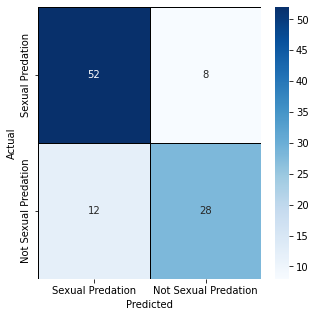

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data_test.Label, prediction_labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Sexual Predation','Not Sexual Predation'], 
            yticklabels = ['Sexual Predation','Not Sexual Predation'])
plt.xlabel("Predicted")
plt.ylabel("Actual")